# 2020 Covid dataset analysed


## Part 1 - Feature Engineering 

In [110]:
import pandas as pd
import os
import numpy as np
import tensorflow as tf
from datetime import datetime
from tensorflow import keras
import matplotlib.pyplot as plt
import pickle

In [30]:
list_of_df= []
for (root, dirs, files) in os.walk(os.path.join(os.getcwd(), "county_data")):
    for file in files:
        if file[-4:] == ".csv": 
            df = pd.read_csv(os.path.join(root, file))
            df = df.dropna()
            if len(df):
                name = df["areaName"][5]
                df = df.drop(df.columns[:3], axis=1)[::-1].reset_index(drop=True)
                df['y'] = df["newCasesBySpecimenDate"]/df["newVirusTestsBySpecimenDate"]
                for i in range(len(df)):
                    if df["newVirusTestsBySpecimenDate"][i]==0:
                        df.loc[i,'y']=0
                df.columns=['Date','Cases','Deaths','Tests','y']
                #df=df.set_index('Date')
                list_of_df.append([name,df])




In [112]:
list_of_df[0][1]["Tests"][6]

10

count    957.000000
mean       0.038918
std        0.048390
min        0.000000
25%        0.007678
50%        0.027778
75%        0.052632
max        0.555556
Name: y, dtype: float64


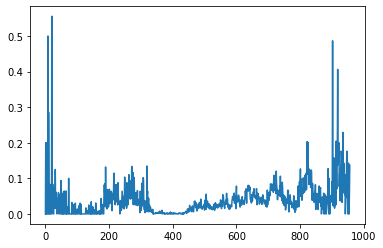

In [113]:
print(list_of_df[16][1].y.describe())
plt.plot(list_of_df[16][1].y)

In [114]:
list_slopes=[]
list_means=[]
for name,data in list_of_df:
    slope, bias = np.polyfit(np.arange(0,data.shape[0]), data.y,1)
    list_slopes.append(slope)
    list_means.append(data.y.mean())

In [115]:
list_slopes

[-7.009352573434715e-05,
 -1.210070596412333e-05,
 1.0924270296073364e-05,
 -2.0524192970930683e-05,
 2.006595093383056e-05,
 1.945946684197738e-05,
 -1.2018401619309772e-05,
 -7.474533231940102e-05,
 -1.7217387846643366e-05,
 -4.388311983779209e-06,
 5.6748354994254236e-06,
 2.856943785056627e-05,
 2.599376530206034e-05,
 2.473585442602515e-05,
 -5.001534209907751e-06,
 -3.926018923010657e-05,
 5.179491050629969e-05,
 -2.6327684556452558e-06,
 3.923584010042349e-06,
 1.3049079947661325e-05,
 -1.5541307305017786e-05,
 2.728561996917576e-05,
 2.4715472430987007e-05,
 1.2991476740786423e-05,
 3.0731495852298025e-05,
 4.895017145299885e-05,
 2.4702871743159333e-05,
 1.0212562507937438e-05,
 2.131646882685008e-05,
 -3.016437475575607e-05,
 7.133410651745553e-06,
 6.976248945578321e-06,
 2.9209488489176565e-06,
 -2.818738759850701e-06,
 1.0876154444565237e-05,
 -2.0070551496553338e-06,
 -7.016067510061868e-05,
 -6.823784136781185e-06,
 -6.141019024327251e-06,
 -3.69094035366433e-07,
 4.0213

In [26]:
list_of_features=['Cases','Deaths','Tests']
list_county=[x[0] for x in list_of_df]

def norm_feature(data,col=None):
    '''
    Given a DataFrame and a column, it normalises the data in a new column called NORM_column
    '''
    if col is None:
        a=(data-data.mean())/data.std()
    else: 
        a=(data[col]-data[col].mean())/data[col].std()
    name='NORM_'+ col
    data[name]=a
    return data

def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std

features=[]
for name,df in list_of_df:
    for feature in list_of_features:
        a='NORM_'+feature
        if a not in features:
            features.append(a)
        if a not in df.columns:
            df = norm_feature(df, col=feature)


AttributeError: 'Series' object has no attribute 'columns'

In [27]:
list_of_df[0][1].describe()


count    970.000000
mean       0.067686
std        0.114433
min        0.000000
25%        0.021164
50%        0.042134
75%        0.076801
max        2.000000
dtype: float64

In [31]:
from sklearn.linear_model import LinearRegression
# from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor


def pipeline(model, county, label):

    def make_lags(ts, lags, lead_time=1):
        return pd.concat(
            {
                f'y_lag_{i}': ts.shift(i)
                for i in range(lead_time, lags + lead_time)
            },
            axis=1)

    # 14 days of lag features
    y= county[label]
    y = y.copy()
    X = make_lags(y, lags=50).fillna(0.0)

    def make_multistep_target(ts, steps):
        return pd.concat(
            {f'y_step_{i + 1}': ts.shift(-i)
            for i in range(steps)},
            axis=1)

    # Eight-week forecast
    y = make_multistep_target(y, steps=30).dropna()

    # Shifting has created indexes that don't match. Only keep times for
    # which we have both targets and features.
    y, X = y.align(X, join='inner', axis=0)

    # Create splits
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)
    
    model.fit(X_train, y_train)


    return model

In [119]:
list_of_features.append('y')

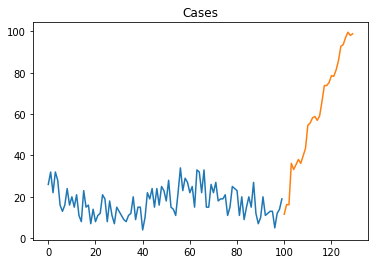

[[11.57818047 16.25282654 16.20158918 36.23532675 33.20515463 35.60648717
  38.05427061 36.17448185 39.77793099 43.33123994 54.60611253 55.73044236
  58.20418328 58.83895862 56.99192955 59.15003559 66.07791105 73.82762099
  73.80670067 75.25993217 78.56640034 78.26353719 81.40523067 85.88508489
  92.81270538 93.5950101  97.05216597 99.58873363 98.05417651 98.85462752]]


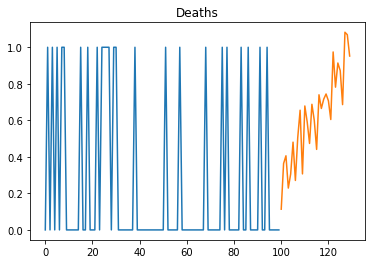

[[0.11343407 0.36349293 0.40584477 0.22904903 0.30620373 0.48058608
  0.27078893 0.50627105 0.6553879  0.30668153 0.67856191 0.59149574
  0.47336314 0.68775448 0.60017999 0.44081465 0.73983503 0.6648479
  0.71582407 0.74418645 0.70670766 0.60447907 0.97429415 0.78149759
  0.9138134  0.87228272 0.68596571 1.08221208 1.06886864 0.95194016]]


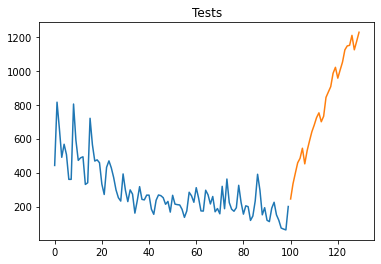

[[ 244.44428843  332.98150504  396.24877091  457.72778432  483.94837297
   543.45178064  451.44114437  528.88351117  585.92182531  640.21309883
   679.81275797  723.94495433  752.15499326  699.58249905  732.07287276
   843.24912889  875.13696689  906.45537249  985.42215341 1020.43293532
   956.60140999 1004.92959592 1051.35476833 1123.33098622 1146.59125227
  1150.05961463 1208.74201762 1123.74822013 1173.92041123 1227.20963454]]


In [47]:
dict_models=dict()
def get_data(n, feat, past_values):
        re = list_of_df[n][1][feat]
        values=list(re)
        X = []
        y = []
        for i in range(len(values)-past_values):
            X.append(values[i:i+past_values])
            y.append(values[i+past_values])
        X = np.array(X)
        y = np.array(y)
        return X, y
for feat in list_of_features:
    model = LinearRegression()
    for i in range(len(list_of_df)//9):
        model = pipeline(model, list_of_df[i][1], feat)
    dict_models[feat]=model

    past_values = 50
    X, y = get_data(100, feat, past_values)
    # X, y = X[:-220], y[:-220]

    plt.plot(y[-100:])

    shift = 0
    x_axis_future = np.arange(100-30*shift, 100-30*(shift-1))
    if shift: y_future = model.predict(X[-1-shift:-shift])
    else: y_future = model.predict(X[-1-shift:])
    plt.plot(x_axis_future, y_future[0])
    if shift == 0: y = np.append(y, y_future)
    plt.title(feat)
    plt.show()
    print(y_future[:20])

In [48]:
for name,mod in dict_models.items():
    with open('model_'+name,'wb') as f:
        pickle.dump(mod,f)

In [50]:
X, y = get_data(100, "Cases", 50)
print(X[-1:])

[[23. 18. 28. 15. 14. 11. 22. 34. 23. 29. 27. 22. 25. 15. 33. 32. 22. 33.
  15. 15. 26. 22. 27. 18. 19. 19. 21. 11. 15. 25. 24. 23. 11. 20.  9. 15.
  20. 15. 27. 12.  7. 10. 20. 11. 12. 13. 13.  5. 12. 14.]]


In [51]:
with open("model_Cases",'rb') as f:
    model_test = pickle.load(f)
y_future = model_test.predict(X[-1:])
print(y_future)

[[11.57818047 16.25282654 16.20158918 36.23532675 33.20515463 35.60648717
  38.05427061 36.17448185 39.77793099 43.33123994 54.60611253 55.73044236
  58.20418328 58.83895862 56.99192955 59.15003559 66.07791105 73.82762099
  73.80670067 75.25993217 78.56640034 78.26353719 81.40523067 85.88508489
  92.81270538 93.5950101  97.05216597 99.58873363 98.05417651 98.85462752]]
